 # Solid angle calculation  - 09.07.2024, Shungo Fukaya

## Note: The solid angle in this code is normalized with $4\pi$, which means the calculated "solid angle" is not in the units of Steradian but it means the "probability" of an emitted photon hitting the area.

In [6]:
import numpy as np
import time
import random
from scipy.special import voigt_profile 
from scipy import integrate 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

## parameters
## radius of electrode [mm]
inner_radius = 14.8
## width of electrode [mm]
wid = 12.7 

# Define solid angle functions
Both circular and square hole cases are written.
The solid angle formula for the circular hole is taken from Equation (25) in Juan Camilo Valencia Estrada et al. Vol. 41, No. 6 / June 2024 / Journal of the Optical Society of America A. The solid angle formula for the square hole is taken from Equation (3) in J. Cook. Nuclear Instruments and Methods 178 (1980) 561-564.

Note: Although the solid angle for a square hole has an analytic expression, that for a circular hole has an integral expression. 
The stochastic integration operation "quad" was used to solve this integral, which makes the calculation ~100 times larger for the circular hole case. Maybe there is a better way to integrate.

In [10]:
def f(theta,b,d,h): #integrand 
    return (d**2 + h**2 -b*d*np.cos(theta))/(np.sqrt(b**2 + d**2 + h**2 -2*b*d*np.cos(theta))*(d**2 + 2*h**2 - d**2*np.cos(2*theta)))
#Important thing to remember for the function you want to integrate using quad is to make the variable you want to integrate over the first argument to the function.

def omega_pt(x_p,y_p,z_p): #circular hole case
    w = 0.29 # radius of hole
    integr, err = integrate.quad(f, 0, 2*np.pi, args=(w, np.sqrt(x_p**2+y_p**2), z_p))
    omega_pt = (2*np.pi-2*z_p*integr)/(4*np.pi) #NORMALIZED WITH 4pi
    return omega_pt
    
def omega_pt_square(x_p,y_p,z_p): #square hole case (copied from Georgia Booton's code)
    w = 0.29 # half the width of hole
    T1 = np.arctan(((w + x_p) * (w + y_p))/(z_p * ((w + x_p)**2 + (w + y_p)**2 + z_p**2)**(1/2)))
    T2 = np.arctan(((w + x_p) * (w - y_p))/(z_p * ((w + x_p)**2 + (w - y_p)**2 + z_p**2)**(1/2)))
    T3 = np.arctan(((w - x_p) * (w + y_p))/(z_p * ((w - x_p)**2 + (w + y_p)**2 + z_p**2)**(1/2)))
    T4 = np.arctan(((w - x_p) * (w - y_p))/(z_p * ((w - x_p)**2 + (w - y_p)**2 + z_p**2)**(1/2)))
    omega_pt_square = (1/(4*np.pi))*(T1+T2+T3+T4) #NORMALIZED WITH 4pi
    return omega_pt_square

In [12]:
omega_pt(0, 0, 3)

0.002319865323295756

## Solid angle plot along the z-axis from the hole

Execution time: 4.754265785217285 seconds


[]

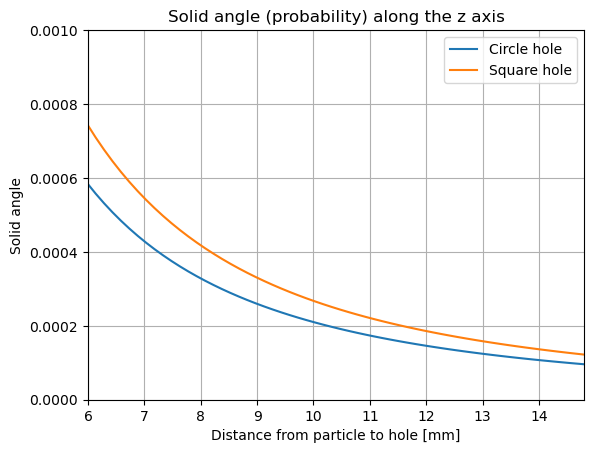

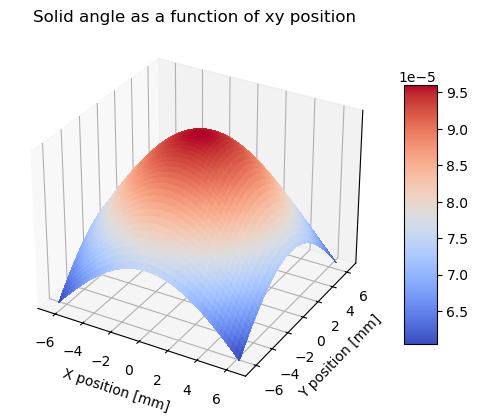

In [15]:
n=100
x_fixed = np.linspace(0,0,n)
y_fixed = np.linspace(0,0,n)

#Solid angle along the z axis
plt.figure()
arr = np.zeros(n)
cnt = 0
for pp in np.linspace(0.01, inner_radius, n):
    arr[cnt] = omega_pt(0, 0, pp) 
    cnt += 1

##Plot as probability ratio
plt.plot(np.linspace(0.01, inner_radius, n), arr, label='Circle hole')
plt.plot(np.linspace(0.01, inner_radius, n), omega_pt_square(x_fixed, y_fixed, np.linspace(0.01, inner_radius, n)), label='Square hole')
plt.title('Solid angle (probability) along the z axis') #At x=0, y=0
plt.ylabel("Solid angle")
plt.xlabel("Distance from particle to hole [mm]")

# ##Plot as solid angle [rad]
# plt.plot(np.linspace(0.01, inner_radius, n), 4*np.pi*arr, label='Circle hole')
# plt.plot(np.linspace(0.01, inner_radius, n), 4*np.pi*omega_pt_square(x_fixed, y_fixed, np.linspace(0.01, inner_radius, n)), label='Square hole')
# plt.title('Solid angle [rad] along the z axis') #At x=0, y=0
# plt.ylabel("Solid angle [rad]")
# plt.xlabel("Distance from particle to hole [mm]")

plt.legend()
plt.grid(True)


plt.xlim([6, inner_radius])
plt.ylim([0,1e-3])


#Solid angle for xy distribution at z=inner_radius
x_p = np.linspace(-wid/2, wid/2, n)
y_p = np.linspace(-wid/2, wid/2, n)

X, Y = np.meshgrid(x_p, y_p)

st = time.time()

##Circular hole
zz = np.array([omega_pt(x_ii, y_ii, inner_radius) for y_ii in y_p for x_ii in x_p])
Z = zz.reshape(n, n)

##Square hole
# z_fixed = np.linspace(inner_radius,inner_radius,n)
# Z = omega_pt_square(X, Y, z_fixed)

print('Execution time:', time.time()-st, 'seconds')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel('X position [mm]')
ax.set_ylabel('Y position [mm]')
ax.set_zlabel('Solid angle')
plt.title("Solid angle as a function of xy position")
fig.colorbar(surf, shrink= 0.7, aspect=8)
ax.set_zticks([])

## Function that return the total solid angle covered by 6 SiPMs for a given point

[Simple case] We assume that the plasma is distributed within a sphere of R=6.6mm in order to make sure that all the emitted photons that enter the holes reach the SiPM. 

In [19]:
# total solid angles for 6 SiPMs
def total_solid_angle(x,y,z): #x,y,z given in the electrode coordinates
    total_angle=0
    phi_prime=np.array([-np.pi/2, -np.pi/6, np.pi/6, np.pi/2, np.pi*5/6, np.pi*7/6]) #[rad]
    for p in phi_prime:
        total_angle += omega_pt(-(x*np.cos(p)+z*np.sin(p)), y, inner_radius-(-x*np.sin(p)+z*np.cos(p))) ###Circular hole
        # total_angle += omega_pt_square(-(x*np.cos(p)+z*np.sin(p)), y, inner_radius-(-x*np.sin(p)+z*np.cos(p))) ###Square hole
    return total_angle

In [22]:
#check symmetry about 60 deg rotation about the electrode y axis
print(total_solid_angle(7,0,0))
print(total_solid_angle(7*np.cos(np.pi/3), 0, 7*np.sin(np.pi/3)))

0.0007221483543511335
0.0007221483543510629


## Test code: Plot xz distribution.

/var/folders/mr/zwv3268d3tdg2spmj9rn_9_c0000gn/T/ipykernel_53821/1149202202.py:29: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(cax=cax)


Text(0.5, 1.0, 'Solid angle distribution on xz plane')

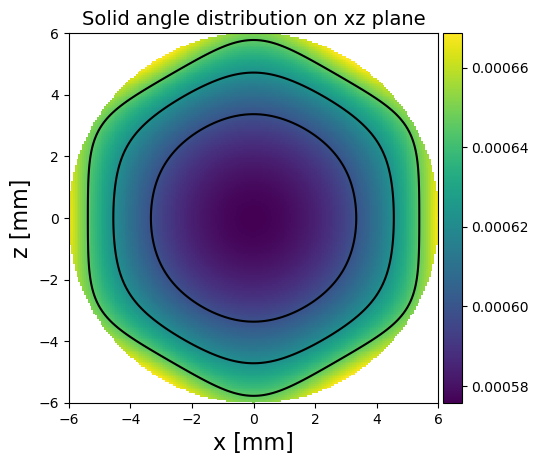

In [173]:
plasma_b = 6
N_points = 200

x_values = np.linspace(-plasma_b, plasma_b, N_points+1)
y_value = 0
z_values = np.linspace(-plasma_b, plasma_b, N_points+1)

plt.figure()
plt.axis("equal")
X,Y = np.meshgrid(x_values, z_values)
z = np.array([total_solid_angle(x_i, y_value, z_i) for z_i in z_values for x_i in x_values])
Z = z.reshape(N_points+1, N_points+1)
for i in range(N_points+1):
    for j in range(N_points+1):
        if x_values[i]**2 +z_values[j]**2 > plasma_b**2:
            Z[i, j]=float("NaN")
plt.xlim([-plasma_b, plasma_b])
plt.ylim([-plasma_b, plasma_b])


vminn=np.nanmin(Z)
vmaxx=np.nanmax(Z)
plt.pcolor(X, Y, Z,vmin=vminn, vmax=vmaxx)
plt.xlabel("x [mm]", fontsize=16)
plt.ylabel("z [mm]", fontsize=16)
ax = plt.subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size ="5%", pad =0.05)
plt.colorbar(cax=cax)
ax.contour(X, Y, Z, np.linspace(vminn, vmaxx, 5), colors='k')
ax.set_title("Solid angle distribution on xz plane", fontsize=14)

/var/folders/mr/zwv3268d3tdg2spmj9rn_9_c0000gn/T/ipykernel_53821/182767485.py:10: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(cax=cax)


Text(0.5, 1.0, 'Solid angle distribution [Sr] on xz plane')

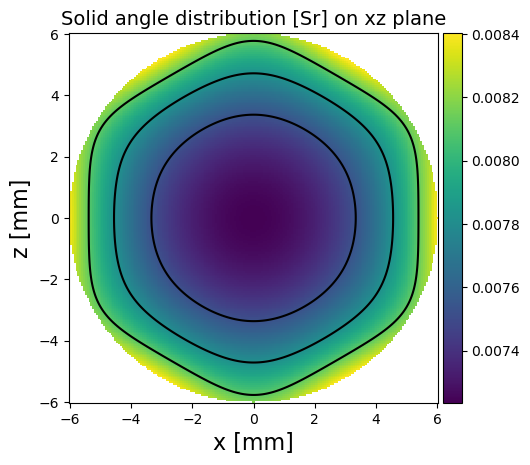

In [177]:
#Plot in units of Steradian: multiply by 4pi
plt.figure()
plt.axis("equal")
plt.pcolor(X, Y, Z*4*np.pi,vmin=vminn*4*np.pi, vmax=vmaxx*4*np.pi)
plt.xlabel("x [mm]", fontsize=16)
plt.ylabel("z [mm]", fontsize=16)
ax = plt.subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size ="5%", pad =0.05)
plt.colorbar(cax=cax)
ax.contour(X, Y, Z*4*np.pi, np.linspace(vminn*4*np.pi, vmaxx*4*np.pi, 5), colors='k')
ax.set_title("Solid angle distribution [Sr] on xz plane", fontsize=14)

In [16]:
# alice=np.linspace(-10,10,10)
# bob=np.linspace(1,3,10)
# z = np.array([a*b  for b in bob for a in alice])
# X,Y = np.meshgrid(alice, bob)
# Ziz = z.reshape(10,10)
# plt.pcolor(alice, bob, Ziz)
# plt.xlabel("alice")
# plt.ylabel("bob")

## Test code: Plot xy distribution.

In [179]:
print(total_solid_angle(3, 2, 0))
print(total_solid_angle(3, 0, 0))

0.0005763848813613648
0.0005943267516343995


/var/folders/mr/zwv3268d3tdg2spmj9rn_9_c0000gn/T/ipykernel_53821/2542456303.py:29: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(cax=cax)


Text(0.5, 1.0, 'Solid angle distribution on xy plane')

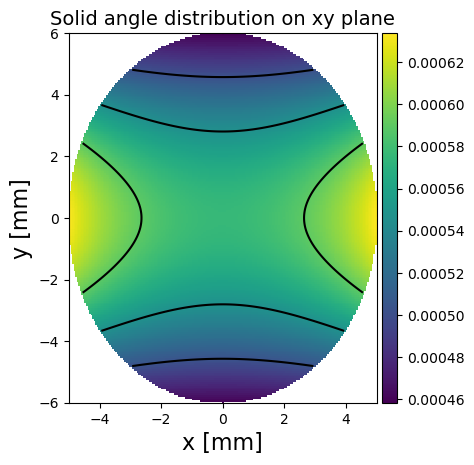

In [181]:
plasma_a = 6
plasma_b = 5
N_points=200

x_values = np.linspace(-plasma_b, plasma_b, N_points+1)
y_values = np.linspace(-plasma_a, plasma_a, N_points+1)
z_value = 0

plt.figure()
plt.axis("equal")
X,Y = np.meshgrid(x_values, y_values)
z = np.array([total_solid_angle(x_i, y_i, z_value) for y_i in y_values for x_i in x_values])
Z = z.reshape(N_points+1, N_points+1)
for i in range(N_points+1):
    for j in range(N_points+1):
        if x_values[i]**2/plasma_b**2 + y_values[j]**2/plasma_a**2 > 1:
            Z[i, j]=float("NaN")
plt.xlim([-plasma_b, plasma_b])
plt.ylim([-plasma_a, plasma_a])

vminn=np.nanmin(Z)
vmaxx=np.nanmax(Z)
plt.pcolor(X, Y, Z,vmin=vminn, vmax=vmaxx)
plt.xlabel("x [mm]", fontsize=16)
plt.ylabel("y [mm]", fontsize=16)
ax = plt.subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes ("right", size ="5%", pad =0.05)
plt.colorbar(cax=cax)
ax.contour(X, Y, Z, np.linspace(vminn, vmaxx, 5), colors='k')
ax.set_title("Solid angle distribution on xy plane", fontsize=14)

/var/folders/mr/zwv3268d3tdg2spmj9rn_9_c0000gn/T/ipykernel_53821/2799672672.py:10: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(cax=cax)


Text(0.5, 1.0, 'Solid angle distribution [Sr] on xy plane')

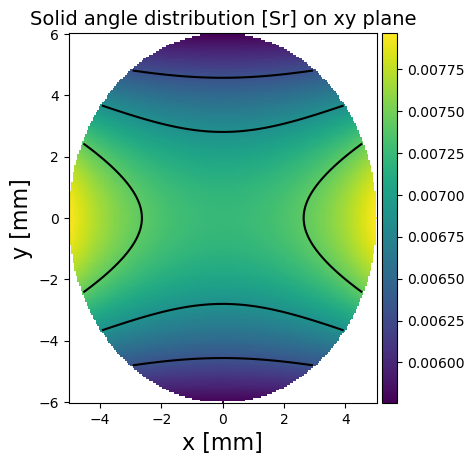

In [182]:
#Plot in units of Steradian: multiply by 4pi
plt.figure()
plt.axis("equal")
plt.pcolor(X, Y, Z*4*np.pi,vmin=vminn*4*np.pi, vmax=vmaxx*4*np.pi)
plt.xlabel("x [mm]", fontsize=16)
plt.ylabel("y [mm]", fontsize=16)
ax = plt.subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes ("right", size ="5%", pad =0.05)
plt.colorbar(cax=cax)
ax.contour(X, Y, Z*4*np.pi, np.linspace(vminn*4*np.pi, vmaxx*4*np.pi, 5), colors='k')
ax.set_title("Solid angle distribution [Sr] on xy plane", fontsize=14)

# General case

When the plasma is far off, then some portion of the photons that passed through the hole will not hit the SiPM but will hit the side wall. To consider this effect we need to estimate the locations of the particle where this happens and the ratio of the photons that hits the SiPM. 
It is difficult to estimate how much photons will reflect on the wall, so we assumed all the photons that hit the walls were absorbed. We must note that the circular area on the irradiated SiPM actually has a distribution of solid angle, but we can reasonably assume that since the hole size is very small and the plasma is far away the solid angle distribution is uniform all over the irradiated area.

In [81]:
# Define the function that gives the ratio of entered photons that hit the SiPM
def side_effect(r, d): #r=r_shadow, d=distance
    R = 1.5  # r_sipm[mm]
    if d >= R+r: #(A)
        overlap=0
    elif R-r >= d: #(E)
        overlap=np.pi*r**2
    else:
        alpha = np.arccos((r**2+d**2-R**2)/(2*r*d))
        beta = np.arccos((R**2+d**2-r**2)/(2*R*d))
        if d >= np.sqrt(R**2-r**2): #(B)
            if d == np.sqrt(R**2-r**2): #(C)
                alpha = np.pi/2
            overlap = beta*R**2 + alpha*r**2 - r**2 * np.sin(2*alpha)/2 - R**2 * np.sin(2*beta)/2
        else: #(D)
            overlap = beta*R**2 + alpha*r**2 + r**2 * np.sin(2*alpha)/2 - R**2 * np.sin(2*beta)/2
    irr_ratio = overlap/(np.pi*r**2) #irradiated ratio
    return irr_ratio

In [91]:
## generalize total_solid_angle
def total_solid_angle_general(x,y,z): #x,y,z given in the electrode coordinates
    total_angle = 0
    phi_prime = np.array([-np.pi/2, -np.pi/6, np.pi/6, np.pi/2, np.pi*5/6, np.pi*7/6]) #[rad]
    for p in phi_prime:
        # get hole coordinates
        x_prime = -(x*np.cos(p)+z*np.sin(p))
        y_prime = y
        z_prime = inner_radius-(-x*np.sin(p)+z*np.cos(p))

        r_shadow = 0.29*(z_prime+2.32)/z_prime
        distance = np.sqrt(x_prime**2 + y_prime**2) *2.32/z_prime
        irr_ratio = side_effect(r_shadow, distance)
        # print(irr_ratio)
        total_angle += omega_pt(x_prime, y_prime, z_prime)*irr_ratio ###Circular hole
    return total_angle

Integrate to the solid angle code from the simple case...

/var/folders/mr/zwv3268d3tdg2spmj9rn_9_c0000gn/T/ipykernel_53821/3540722241.py:29: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(cax=cax)


Text(0.5, 1.0, 'Solid angle distribution on xy plane')

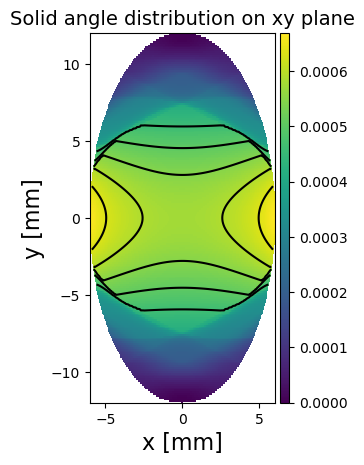

In [125]:
plasma_a = 12
plasma_b = 6
N_points=200

x_values = np.linspace(-plasma_b, plasma_b, N_points+1)
y_values = np.linspace(-plasma_a, plasma_a, N_points+1)
z_value = 0

plt.figure()
plt.axis("equal")
X,Y = np.meshgrid(x_values, y_values)
z_gen = np.array([total_solid_angle_general(x_i, y_i, z_value) for y_i in y_values for x_i in x_values])
Z_gen = z_gen.reshape(N_points+1, N_points+1)
for i in range(N_points+1):
    for j in range(N_points+1):
        if x_values[i]**2/plasma_b**2 + y_values[j]**2/plasma_a**2 > 1:
            Z_gen[i, j]=float("NaN")
plt.xlim([-plasma_b, plasma_b])
plt.ylim([-plasma_a, plasma_a])

vminn_gen=np.nanmin(Z_gen)
vmaxx_gen=np.nanmax(Z_gen)
plt.pcolor(X, Y, Z_gen, vmin=vminn_gen, vmax=vmaxx_gen)
plt.xlabel("x [mm]", fontsize=16)
plt.ylabel("y [mm]", fontsize=16)
ax = plt.subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes ("right", size ="5%", pad =0.05)
plt.colorbar(cax=cax)
ax.contour(X, Y, Z_gen, np.linspace(vminn, vmaxx, 5), colors='k')
ax.set_title("Solid angle distribution on xy plane", fontsize=14)

In [119]:
# plt.figure()
# plt.axis("equal")
# plt.pcolor(X, Y, Z_gen-Z, vmin=-.0000001, vmax=.0000001)
# ax = plt.subplot()
# divider = make_axes_locatable(ax)
# cax = divider.append_axes ("right", size ="5%", pad =0.05)
# plt.colorbar(cax=cax)

/var/folders/mr/zwv3268d3tdg2spmj9rn_9_c0000gn/T/ipykernel_53821/4123828840.py:10: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(cax=cax)


Text(0.5, 1.0, 'Solid angle distribution [Sr] on xy plane')

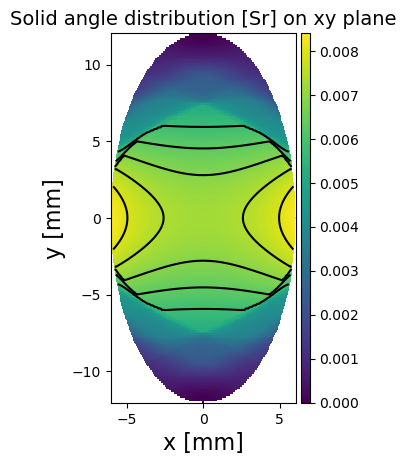

In [167]:
#Plot in units of Steradian: multiply by 4pi
plt.figure()
plt.axis("equal")
plt.pcolor(X, Y, Z_gen*4*np.pi, vmin=vminn_gen*4*np.pi, vmax=vmaxx_gen*4*np.pi)
plt.xlabel("x [mm]", fontsize=16)
plt.ylabel("y [mm]", fontsize=16)
ax = plt.subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes ("right", size ="5%", pad =0.05)
plt.colorbar(cax=cax)
ax.contour(X, Y, Z_gen*4*np.pi, np.linspace(vminn*4*np.pi, vmaxx*4*np.pi, 5), colors='k')
ax.set_title("Solid angle distribution [Sr] on xy plane", fontsize=14)

[  0  25  50  75 100]


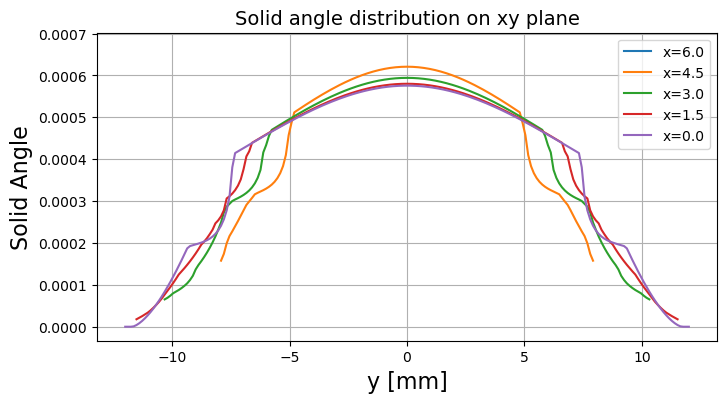

In [165]:
cut_N = np.array([0,1,2,3,4])*N_points/8 #N_points=[0,1,...,199,200]
cut_N = cut_N.astype(int)
x_gridsize = plasma_b*2/N_points

print(cut_N)
plt.figure(figsize=(8,4))
for NN in cut_N:
    # print(Z_gen[:,NN])
    plt.plot(y_values, Z_gen[:,NN], label = "x="+str(plasma_b - NN*x_gridsize)) 
plt.title("Solid angle distribution on xy plane", fontsize=14)
plt.ylabel("Solid Angle", fontsize=16)
plt.xlabel("y [mm]", fontsize=16)
plt.grid(True)
plt.legend()

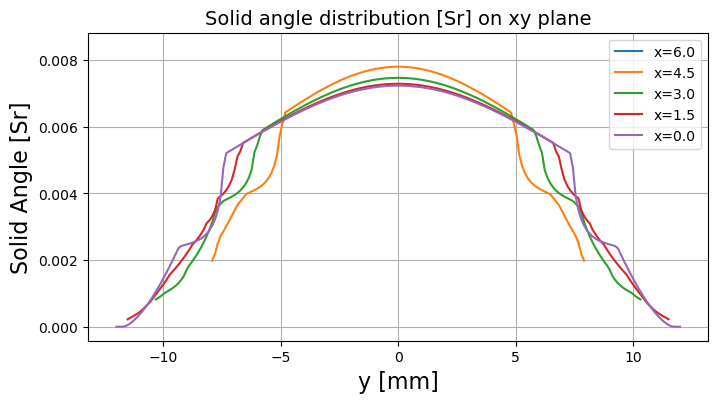

In [169]:
#Plot in units of Steradian: multiply by 4pi
plt.figure(figsize=(8,4))
for NN in cut_N:
    # print(Z_gen[:,NN])
    plt.plot(y_values, Z_gen[:,NN]*4*np.pi, label = "x="+str(plasma_b - NN*x_gridsize)) 
plt.title("Solid angle distribution [Sr] on xy plane", fontsize=14)
plt.ylabel("Solid Angle [Sr]", fontsize=16)
plt.xlabel("y [mm]", fontsize=16)
plt.grid(True)
plt.legend()

# !!!!Don't run the code below if not necessary! It takes time to run!!!!

## Function that return the average solid angle for a uniformly distributed plasma with dimensions a,b

In [200]:
# Average solid angle for a uniformly distributed plasma
# Integrate over volume using the Monte Carlo method. 
def solid_angle_plasma(a,b):
    # Start Monte Carlo
    M=1000
    diff=1
    aver=1
    pass_count=0
    tol = 1e-6 #convergence criteria
    while pass_count<3 or diff > tol: 
        new_aver=0
        count=0 #number of particles inside the ellipsoid
        for j in range(M):
            r_x = random.uniform(-b, b)
            r_y = random.uniform(-a+3.25, a+3.25) #Take into account the shift towards the y axis
            r_z = random.uniform(-b, b)
            if r_x**2/b**2 + (r_y-3.25)**2/a**2 + r_z**2/b**2 <= 1: #if inside ellipsoid
                count += 1
                new_aver += total_solid_angle_general(r_x,r_y,r_z)
        new_aver = new_aver/count
        diff = np.abs(new_aver-aver)
        aver = new_aver
        print("count=", count, " average solid angle=", aver)
        M = M*2
        if diff < tol: #iterate 3 times with same M if converged
            pass_count+=1
            M=int(M/2)
    return aver


In [202]:
solid_angle_plasma(3,3)

count= 504  average solid angle= 0.0005353860026925478
count= 1073  average solid angle= 0.0005373936355271675
count= 2193  average solid angle= 0.0005362823693069415
count= 4170  average solid angle= 0.0005370673082000589
count= 4098  average solid angle= 0.0005372216436207249
count= 4124  average solid angle= 0.0005362215090537251
count= 8415  average solid angle= 0.0005360245544495512


0.0005360245544495512

In [204]:
solid_angle_plasma(5,3)

count= 533  average solid angle= 0.0005213384891799674
count= 1042  average solid angle= 0.0005228664439562997
count= 2088  average solid angle= 0.0005228028855836044
count= 2012  average solid angle= 0.000521806215898062
count= 2113  average solid angle= 0.000524675044460149
count= 4168  average solid angle= 0.0005229626108233995
count= 8381  average solid angle= 0.0005234762808153351


0.0005234762808153351

In [211]:
solid_angle_plasma(8,3)

count= 554  average solid angle= 0.0004843392666053634
count= 1068  average solid angle= 0.00048190857671356955
count= 2156  average solid angle= 0.0004777800994383134
count= 4265  average solid angle= 0.00047852742527928696
count= 4214  average solid angle= 0.00047889060880688104
count= 4294  average solid angle= 0.0004776682937516742
count= 8333  average solid angle= 0.00047875580840236266
count= 16714  average solid angle= 0.000479266357990811


0.000479266357990811

In [213]:
solid_angle_plasma(3,5)

count= 520  average solid angle= 0.0005480432396753145
count= 1045  average solid angle= 0.0005448898793532128
count= 2074  average solid angle= 0.000544272753976786
count= 2057  average solid angle= 0.0005441058869767261
count= 2119  average solid angle= 0.0005448713863019779


0.0005448713863019779

In [217]:
solid_angle_plasma(5,5)

count= 509  average solid angle= 0.0005299514990372979
count= 1066  average solid angle= 0.0005204521631355847
count= 2127  average solid angle= 0.000529346174060385
count= 4210  average solid angle= 0.0005244782982340931
count= 8379  average solid angle= 0.000523573241028888
count= 8371  average solid angle= 0.0005235392777583243
count= 8439  average solid angle= 0.0005245040312553764


0.0005245040312553764

In [221]:
solid_angle_plasma(8,5)

count= 491  average solid angle= 0.00047985580706540496
count= 1037  average solid angle= 0.00048320188941698624
count= 2092  average solid angle= 0.0004779540405528611
count= 4173  average solid angle= 0.0004744146952877707
count= 8314  average solid angle= 0.00047386040914064036
count= 8348  average solid angle= 0.0004745601645710473
count= 8364  average solid angle= 0.0004750327329106061


0.0004750327329106061

# Other parameters

## Laser detuning vs fluorescent count rate.
The formula is taken from the BASE Collaboration, "Trap-integrated fluorescence detection based on silicon photomultipliers in a
cryogenic Penning trap," August 3, 2023.
It basically says that the fluorescent count rate has a Voigt profile with HFWM $\gamma=\gamma_0\sqrt{1+\frac{P}{P_0}}$ and std $\sigma$, where it is assumed that Gaussian broadening is solely due to thermal Doppler effect $\sigma=\sqrt{\frac{k_BT}{mc^2}}f_0=1.012*10^{-7}*\sqrt{T[K]}f_0$ (formula taken from Wiki "Doppler Broadening"). Here, $\gamma_0$ is the natural linewidth $\gamma_0$=19.6MHz, $f_0$ is the resonance frequency $f_0=957803380$[MHz] which corresponds to 313nm wavelength, $P_0$ is the saturation power, and the paper fitted the $P_0$s to be $P_0$=212uW for Run 1 and $P_0$=326uW for Run 2. I will just take $P_0$=300uW for now. Note that $P/P_0\rightarrow \infty$ is the case of saturated transition.

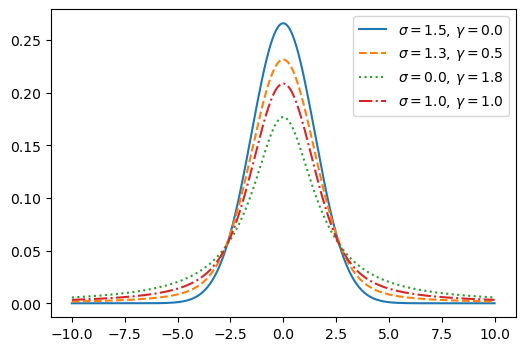

In [225]:
#Plot Voigt profile for different params. Here, the profile is normalized so that the infinite integral over x is 1.
fig, ax = plt.subplots(figsize=(6, 4))
x = np.linspace(-10, 10, 500)
parameters_list = [(1.5, 0., "solid"), (1.3, 0.5, "dashed"),
                   (0., 1.8, "dotted"), (1., 1., "dashdot")]
for params in parameters_list:
    sigma, gamma, linestyle = params
    voigt = voigt_profile(x, sigma, gamma)
    ax.plot(x, voigt, label=rf"$\sigma={sigma},\, \gamma={gamma}$",
            ls=linestyle)
ax.legend()
plt.show()

In [254]:
def gamma_s(T,f_0, f_laser, P): #scattering rate or fluorescence count rate (FCR)
    #get Voigt profile with temperature T[K], central frequency f_0[MHz], laser power P[uW].
    #this also gives the value of emission probability we get for an applied laser frequency f_laser[MHz].
    P_0 = 300 #[uW]
    sigma = 1.012*10**(-7)*np.sqrt(T)*f_0
    print("Std of thermal Doppler effect is", sigma, "[MHz]")
    gamma = 19.6*np.sqrt(1+P/P_0) #power broadened natural linewidth
    fig, ax = plt.subplots(figsize=(6, 4))
    x = np.linspace(-100, 100, 500)
    FCR = 1/2 * np.pi**2 * gamma**2 * (P/P_0) * (1+P/P_0)**(-3/2) * voigt_profile(x, sigma, gamma)
    ax.plot(x, FCR, label=rf"$\sigma={sigma},\, \gamma={gamma}$",
            ls="solid")
    ax.set_xlabel("Laser detuning $f_{laser}-f_0$[MHz]")
    ax.set_ylabel("Fluorescence Count Rate [MHz]")
    ax.set_title("Fluorescence Count Rate $\gamma_s$ of Be$^+$") 
    print("Fluorescence Count Rate at f_laser=", f_laser, "is", 1/2 * np.pi**2 * gamma**2 * (P/P_0) * (1+P/P_0)**(-3/2) * voigt_profile(f_laser-f_0, sigma, gamma), "[MHz]")
    ax.plot(f_laser-f_0, 1/2 * np.pi**2 * gamma**2 * (P/P_0) * (1+P/P_0)**(-3/2) * voigt_profile(f_laser-f_0, sigma, gamma),marker='o', color='r')
    ax.grid() 
    ax.legend()
    plt.show()


<>:15: SyntaxWarning: invalid escape sequence '\g'
<>:15: SyntaxWarning: invalid escape sequence '\g'
/var/folders/mr/zwv3268d3tdg2spmj9rn_9_c0000gn/T/ipykernel_53821/2284970401.py:15: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title("Fluorescence Count Rate $\gamma_s$ of Be$^+$")


Std of thermal Doppler effect is 9.6929702056 [MHz]
Fluorescence Count Rate at f_laser= 957803390 is 12.841401570524866 [MHz]


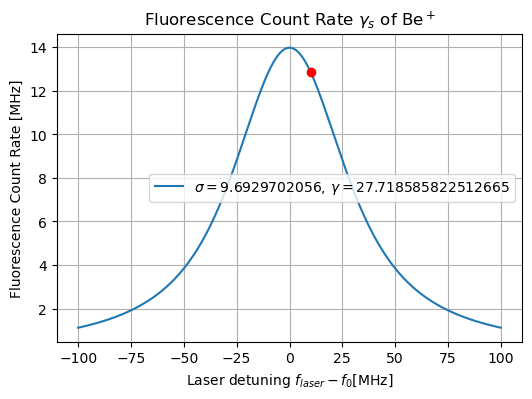

In [256]:
gamma_s(0.01, 957803380, 957803390, 300) #T=10mK 

In [ ]:
SiPM_efficiency = 0.025# taken from the BASE paper
Mesh_transparency = 0.5625 # transparency of the copper mesh on the SiPM array

In [ ]:
def TDR(N, gamma_s, PDE, total_solid_angle):
    TDR = N*gamma_s*PDE*total_solid_angle
    return TDR